# [Computational Social Science] Project 4: Unsupervised Learning

### Group Members: Pei-Ming Chen, Reubén Pérez Lama, Ángel Mendiola Ross

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [35]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras import layers

In [36]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

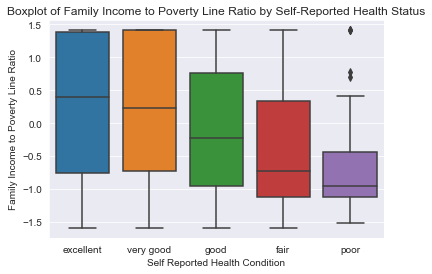

In [37]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Get the target: binary "self-reported health condition"
y = nhanes_scaled['HSD010_binary']
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

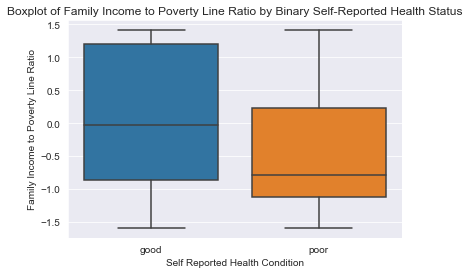

In [38]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

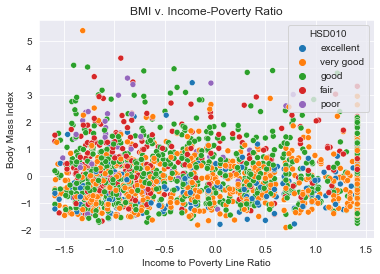

In [39]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop the two target variables.

In [40]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

In [41]:
nhanes_scaled

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83694,0.0,0.261930,0.0,0.324834,-0.481375,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.998146,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,1.087115,-0.683338,0.612440
83696,0.0,0.495138,0.0,0.324834,1.093063,0.634362,-0.194202,-0.057306,0.128246,-0.189513,...,0.998146,0.383802,0.246091,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
83704,0.0,0.728346,0.0,-3.078499,0.305844,-0.268620,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,2.031441,2.065262,1.125008,0.0,0.480384,-0.919866,-0.683338,-1.632812


## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components.
- Plot a barplot of the variation explains by each component.
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

We train a PCA to identify the number of components necessary to explain 75 percent of the variance of our original 241 features. We find that we need 73 components to explain 75 percent of the variance.

In [42]:
# training PCA to pick a number of components that explain 75% of variance
pca = PCA(.75) 
pc_nhanes = pca.fit_transform(nhanes_scaled)

In [43]:
pca.n_components_

73

In [44]:
# cumulative variance explained
np.cumsum(pca.explained_variance_ratio_)

array([0.10201961, 0.17824972, 0.22196164, 0.25078336, 0.27435468,
       0.29337098, 0.3114795 , 0.32803542, 0.34360659, 0.35892855,
       0.37212819, 0.38425608, 0.39583545, 0.40739526, 0.41849532,
       0.42854115, 0.43797338, 0.44729662, 0.45610078, 0.46479099,
       0.47319206, 0.4814524 , 0.48941416, 0.49724189, 0.50477969,
       0.51201626, 0.51912707, 0.52606764, 0.53286135, 0.53931856,
       0.54571504, 0.5520326 , 0.55825065, 0.56442842, 0.57035655,
       0.57613124, 0.58181671, 0.58744696, 0.59306388, 0.59861967,
       0.60411449, 0.60954556, 0.61486139, 0.62014139, 0.62535959,
       0.63052145, 0.63563089, 0.64065079, 0.64563673, 0.6505925 ,
       0.65550404, 0.66034692, 0.66516863, 0.66991909, 0.67464112,
       0.67927949, 0.6839046 , 0.68849283, 0.69300568, 0.6974949 ,
       0.70196563, 0.70635281, 0.71072906, 0.71506344, 0.71935534,
       0.7236165 , 0.7278534 , 0.73205863, 0.73620791, 0.74032771,
       0.74440631, 0.74846653, 0.75251017])

In [45]:
# variance explained
pca.explained_variance_ratio_

array([0.10201961, 0.07623011, 0.04371192, 0.02882172, 0.02357132,
       0.0190163 , 0.01810852, 0.01655592, 0.01557116, 0.01532197,
       0.01319964, 0.01212789, 0.01157937, 0.01155981, 0.01110007,
       0.01004583, 0.00943223, 0.00932324, 0.00880416, 0.00869021,
       0.00840107, 0.00826033, 0.00796176, 0.00782774, 0.00753779,
       0.00723657, 0.00711081, 0.00694057, 0.00679371, 0.00645721,
       0.00639648, 0.00631756, 0.00621805, 0.00617777, 0.00592812,
       0.0057747 , 0.00568547, 0.00563025, 0.00561693, 0.00555579,
       0.00549482, 0.00543107, 0.00531583, 0.00527999, 0.0052182 ,
       0.00516186, 0.00510944, 0.0050199 , 0.00498593, 0.00495577,
       0.00491155, 0.00484288, 0.00482171, 0.00475046, 0.00472203,
       0.00463836, 0.00462512, 0.00458823, 0.00451285, 0.00448922,
       0.00447073, 0.00438718, 0.00437625, 0.00433438, 0.0042919 ,
       0.00426116, 0.0042369 , 0.00420523, 0.00414929, 0.0041198 ,
       0.00407859, 0.00406022, 0.00404364])

The first four principal components explain 25 percent of the variation in our features and it takes until component 25 to explain 50 percent of the variation. To reach 75 percent of variation explained, we need 73 componenents.

### Barplot of Components

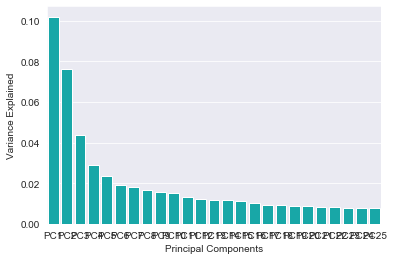

In [46]:
# plotting the first 25 components
df = pd.DataFrame({'var':pca.explained_variance_ratio_[:25],
             'PC':['PC1','PC2','PC3','PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
                  'PC11','PC12','PC13','PC14', 'PC15', 'PC16', 'PC17', 'PC18', 'PC19', 'PC20',
                  'PC21', 'PC22', 'PC23', 'PC24', 'PC25']})
sns.barplot(x='PC',y="var", 
           data=df, color="c")
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained');

### How many components will you use to fit a supervised learning model?

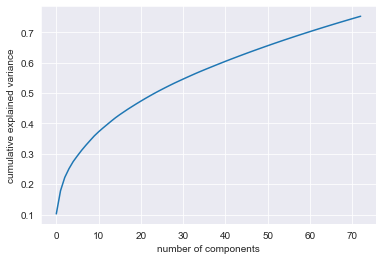

In [47]:
# plotting cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

The "elbow" of the bar plot above, or the point at which the proportion of variance explained by each subsequent principal component drops off, occurs around 5 principle components. Cumulative variance explained is only 29 percent at 5 principal components, however. We trained our PCA model to find the number of components that explain 75 percent of the variance in the original dataset and found that we needed 73 components. Given that our original dataset had 241 features, we need a large number of components to capture all of that variation.

### 2D Scatterplot of the first two components

In [48]:
# creating dataframe to plot
pca_df = pd.DataFrame(data = pc_nhanes)
finalDf = pd.concat([pca_df, hsd010], axis = 1)
# Recode the binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
finalDf['HSD010_binary'] = hsd010_binary = finalDf['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
finalDf

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,HSD010,HSD010_binary
0,9.527811,-0.816224,-1.867091,-2.109908,-3.929375,-0.185332,-3.845128,-2.934825,1.514138,0.682613,...,-0.026077,-0.111519,0.197613,-0.540302,-0.022570,0.661159,0.064213,1.288223,1,good
1,-5.838339,-3.692573,3.805749,-1.029680,0.394578,1.593149,2.711101,-0.740594,0.384751,-2.406291,...,0.793416,-0.192452,-0.695563,-2.558341,-1.288077,2.251621,3.050019,-0.598845,1,good
2,-0.719454,-2.573200,0.907904,-4.755854,-1.798847,0.863651,-1.024494,0.633063,0.542111,0.449352,...,-0.665716,0.357908,0.610626,1.421272,1.329021,0.180090,0.013161,-0.257282,2,good
3,3.533627,-2.576982,-3.249124,-0.405426,3.999037,1.444511,-1.182086,0.326650,-4.151250,-1.245445,...,0.771245,0.744286,-0.498787,0.402388,0.120576,-0.506315,-1.067474,0.222328,2,good
4,-6.872094,-4.194241,0.886831,-0.848954,-0.524848,0.073034,0.843855,0.987843,0.556969,-0.045043,...,-1.898364,0.034410,0.190361,1.065151,1.020083,-0.095923,-0.366110,-0.001839,3,good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2059,2.643319,-1.689356,-0.702592,-0.538271,-1.021631,-0.677038,0.473200,-0.289046,0.958981,-1.238172,...,0.500160,-0.149571,0.088176,0.117401,-0.022639,-0.625987,-0.129781,-0.063768,3,good
2060,1.037906,-0.118065,5.556454,1.630069,0.967776,1.146811,1.949434,0.929057,-1.286747,-2.011509,...,-0.474300,-0.916815,0.441574,0.509740,-0.758913,-0.948926,0.742519,-0.581724,2,good
2061,1.130253,-0.970432,3.415389,1.206787,-3.631819,1.118396,1.361640,1.827686,-2.339055,0.232205,...,-0.926699,0.556418,0.107733,-0.212131,1.578736,0.589650,-0.879778,0.554619,4,poor
2062,7.145093,-0.376752,1.753506,-0.939028,-4.665513,3.844304,-1.355161,2.587567,-0.289915,0.612763,...,-0.003133,-0.154807,1.503797,0.153510,0.612426,-1.037661,0.238035,-0.087599,1,good


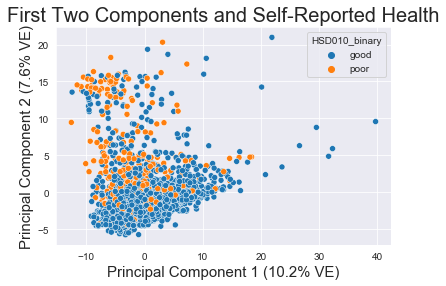

In [49]:
ax = sns.scatterplot(x = finalDf[0], y = finalDf[1], hue = finalDf['HSD010_binary'])
ax.set_xlabel('Principal Component 1 (10.2% VE)', fontsize = 15)
ax.set_ylabel('Principal Component 2 (7.6% VE)', fontsize = 15)
ax.set_title('First Two Components and Self-Reported Health', fontsize = 20)
plt.show()

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

K-means clustering is the process of partitioning the dataset into K distinct, non-overlapping groups where each data point belongs to only one group. That is, it tries to make the intra-cluster data points as similar as possible while also keeping the clusters as different (far) as possible. It assigns data points to a cluster such that the sum of squared distance between the data points and the cluster’s centroid (mean of all data points that belong to that cluster) is at a minimum. The less variation there is within the cluster, the more homogeneous the data points are within the same cluster.

First we import KMeans and numpy so that we can make our arrays. The %matplotlib inline will make our plots show up within the notebook

In [50]:
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [51]:
X = nhanes_scaled

In [52]:
X.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812


Note that the different categories have different ranges. If we don't normalize them, then columns with wider ranges will have disproportionate contributions to cluster separations.

In [53]:
#Set random seed
np.random.seed(10)

In [54]:
#Building and fitting the model
inertia = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    inertia.append(kmeanModel.inertia_)

Plotting Distortions of K-Means

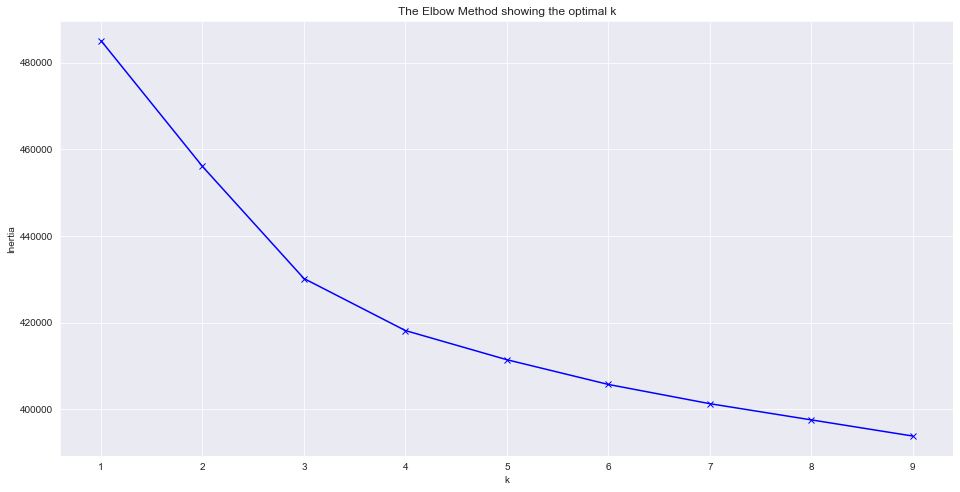

In [55]:
plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We can observe that the “elbow” is the number 4 which is optimal for this case. Now we can run a K-Means using as n_clusters the number 4.

In [56]:
kmeans = KMeans(n_clusters=4,
               max_iter=300 #default
               ).fit(X)

We can access the centers of the clusters through the cluster_centers_ attribute. To get the labels (i.e. the corresponding cluster) we use labels_.

In [57]:
#This is where the label output of the KMeans we just ran lives. We are making it into a dataframe so we can concatenate back to the original data
labels = pd.DataFrame(kmeans.labels_)

The concatenated dataframe will have NaNs in the mismatched rows. Since we don't need to keep the indices the way they are, We will use df.reset_index(drop=True, inplace=True) on both datasets before concatenating to fix the problem.

In [58]:
labels.reset_index(drop=True, inplace=True)
X.reset_index(drop=True, inplace=True)

In [59]:
# Concatenate the two datasets
kdf= pd.concat([X, labels], axis = 1)
kdf=kdf.rename({0:'labels'}, axis=1)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

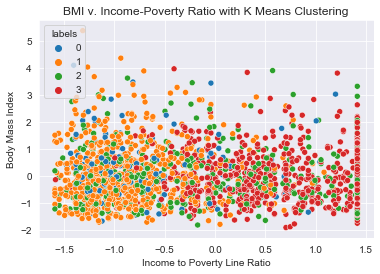

In [60]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "labels", palette = "tab10", data = kdf)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio with K Means Clustering")
plt.show()

Clusters 1 and 3 have less variation than the other clusters. For example, most of the data points for cluster 1 (orange) are concentrated in the left side of the graph, showing 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [61]:
kmeans_PC = KMeans(n_clusters=4,
               max_iter=300 #default
               ).fit(pca_df)

In [62]:
#This is where the label output of the KMeans we just ran lives. We are making it into a dataframe so we can concatenate back to the original data
labels2 = pd.DataFrame(kmeans_PC.labels_)

In [63]:
kpc= pd.concat([pca_df, labels2], axis = 1)
kpc.columns = [*kpc.columns[:-1], 'labels']

In [64]:
kpc.head()

,0,1,2,3,4,5,6,7,8,9,...,64,65,66,67,68,69,70,71,72,labels
0,9.527811,-0.816224,-1.867091,-2.109908,-3.929375,-0.185332,-3.845128,-2.934825,1.514138,0.682613,...,-0.576940,-0.026077,-0.111519,0.197613,-0.540302,-0.022570,0.661159,0.064213,1.288223,0
1,-5.838339,-3.692573,3.805749,-1.029680,0.394578,1.593149,2.711101,-0.740594,0.384751,-2.406291,...,0.340749,0.793416,-0.192452,-0.695563,-2.558341,-1.288077,2.251621,3.050019,-0.598845,2
2,-0.719454,-2.573200,0.907904,-4.755854,-1.798847,0.863651,-1.024494,0.633063,0.542111,0.449352,...,0.163233,-0.665716,0.357908,0.610626,1.421272,1.329021,0.180090,0.013161,-0.257282,3
3,3.533627,-2.576982,-3.249124,-0.405426,3.999037,1.444511,-1.182086,0.326650,-4.151250,-1.245445,...,-0.465012,0.771245,0.744286,-0.498787,0.402388,0.120576,-0.506315,-1.067474,0.222328,3
4,-6.872094,-4.194241,0.886831,-0.848954,-0.524848,0.073034,0.843855,0.987843,0.556969,-0.045043,...,-0.188344,-1.898364,0.034410,0.190361,1.065151,1.020083,-0.095923,-0.366110,-0.001839,2


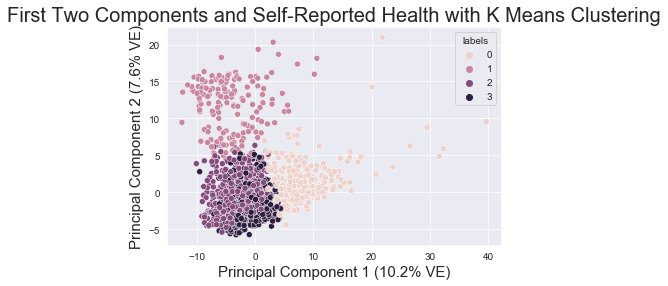

In [65]:
ax = sns.scatterplot(x = kpc[0], y = kpc[1], hue = kpc['labels'])
ax.set_xlabel('Principal Component 1 (10.2% VE)', fontsize = 15)
ax.set_ylabel('Principal Component 2 (7.6% VE)', fontsize = 15)
ax.set_title('First Two Components and Self-Reported Health with K Means Clustering', fontsize = 20)
plt.show()

## Your Answer Here

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features
We choose to predict hsd010_binary in our model. Here we use a simple sequential model with a single hidden layer with 16 nodes.

In [114]:
y = hsd010_binary.map({'good': 1, 'poor': 0}).to_numpy()
X = nhanes_scaled.to_numpy()
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

(2064, 241)


In [105]:
model = Sequential()

model.add(
    layers.Dense(16, input_dim=X.shape[1], activation='relu')
)

model.add(
    layers.Dense(1,  activation= 'relu')
)

## Add any additional layers you wish here

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                1200      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 17        
Total params: 1,217
Trainable params: 1,217
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
49/49 [==============================] - 0s 3ms/step - loss: 5.4952 - accuracy: 0.5155 - val_loss: 4.1282 - val_accuracy: 0.6066
Epoch 2/20
49/49 [==============================] - 0s 1ms/step - loss: 3.5971 - accuracy: 0.6596 - val_loss: 3.0310 - val_accuracy: 0.6996
Epoch 3/20
49/49 [==============================] - 0s 1ms/step - loss: 2.9215 - accuracy: 0.7358 - val_loss: 2.7110 - val_accuracy: 0.7558
Epoch 4/20
49/49 [==============================] - 0s 977us/step - loss: 2.5919 - accur

### Neural Network on Principal Components
Here we train the a neural model with the same structure using the projection on the first 5 principal components as features.

In [110]:
## Your Answer Here
y = hsd010_binary.map({'good': 1, 'poor': 0}).to_numpy()
X = pca_df[range(5)].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)
print(X.shape)

(2064, 5)


In [111]:
model = Sequential()

model.add(
    layers.Dense(16, input_dim=X.shape[1], activation='relu')
)

model.add(
    layers.Dense(1,  activation= 'relu')
)

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 16)                96        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
49/49 [==============================] - 0s 3ms/step - loss: 12.8866 - accuracy: 0.1641 - val_loss: 13.0933 - val_accuracy: 0.1512
Epoch 2/20
49/49 [==============================] - 0s 1ms/step - loss: 12.8853 - accuracy: 0.1641 - val_loss: 13.0707 - val_accuracy: 0.1512
Epoch 3/20
49/49 [==============================] - 0s 955us/step - loss: 12.8774 - accuracy: 0.1641 - val_loss: 13.0683 - val_accuracy: 0.1512
Epoch 4/20
49/49 [==============================] - 0s 1ms/step - loss: 12.8117 - ac

### Neural Network on Principal Components + Cluster Membership
Here we train the a neural model with the same structure using the projection on the first 5 principal components and cluster membership as features.

In [112]:
## Your Answer Here
y = hsd010_binary.map({'good': 1, 'poor': 0}).to_numpy()
X = pd.concat([pca_df[range(5)], labels], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)
print(X.shape)

(2064, 6)


In [113]:
model = Sequential()

model.add(
    layers.Dense(16, input_dim=X.shape[1], activation='relu')
)

model.add(
    layers.Dense(1,  activation= 'relu')
)

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print(model.summary())

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32, verbose=1)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 16)                112       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
49/49 [==============================] - 0s 3ms/step - loss: 10.2679 - accuracy: 0.2158 - val_loss: 9.0735 - val_accuracy: 0.2558
Epoch 2/20
49/49 [==============================] - 0s 990us/step - loss: 8.5524 - accuracy: 0.3204 - val_loss: 7.8469 - val_accuracy: 0.3585
Epoch 3/20
49/49 [==============================] - 0s 1ms/step - loss: 6.7483 - accuracy: 0.3863 - val_loss: 5.5015 - val_accuracy: 0.4186
Epoch 4/20
49/49 [==============================] - 0s 1ms/step - loss: 4.8659 - accuracy

After training for 20 epochs, the three models achieve accuracies of 0.8353, 0.7190, and 0.8062 respectively. Even though the last model only use the first 5 principal components and cluster membership as features, it achieve similar accuracy as the first model which uses the entire 241 features. Therefore we believe that a combination of PCA and clustering is the best featurization method among the three, as it strikes a nice balance between parsimony/interpretability and accuracy.

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

## Your Answer Here

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

## Your Answer Here

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

In [ ]:
## Your Answer Here